In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+2],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+4],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+6],i)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    
    for i in range(n):
        circuit.ry(params[i+8],i)

In [5]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 2  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,10)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,10)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer5Hard/quantum_loss_hard_layer5_%d.npy' %i
    f2 = 'Layer5Hard/opt_params_hard_layer5_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696]
[0.7695346868393912, 0.6093752274676282, 0.532772529300042, 0.496769543818677, 0.4712028520801584, 0.44367993289993307, 0.4123992299340446, 0.37913116432756744, 0.34605918868821106, 0.3148096650645442, 0.28634482432469327, 0.26115424581534236, 0.23948318713503033, 0.2214316344541992, 0.2068517980419294, 0.19513778411849633, 0.18515311566259204, 0.17550464784229614, 0.1650900170129288, 0.15357014022849416, 0.1414636127469444, 0.12985819381612354, 0.11995134766327933, 0.11262867667816212, 0.10818647758022724, 0.10623864771415353, 0.1058310999597068, 0.10575767839887225, 0.10498394113974362, 0.10299177253744761, 0.0998744387638496, 0.09615702553540725, 0.09246414761674791, 0.08920423328060109, 0.0863984848133366, 0.08370521587301206, 0.08061035294109938, 0.07669287206401175, 0.07184759206578262, 0.06636606109787611, 0.0608360843897372, 0.055900445175647864, 0.05198212

[0.7215202746197147, 0.5382700520643097, 0.42089795885377423, 0.34496766428794623, 0.29724489189699566, 0.2682455657629394, 0.24703957363685455, 0.22283255962033124, 0.19105764014466864, 0.1546054933006088, 0.11948797592707454, 0.09119354297275753, 0.07318826976393618, 0.06654982477372391, 0.06993332602924765, 0.07982288242997942, 0.09141823414048668, 0.1001443135611908, 0.10307943022670915, 0.09957019730244165, 0.0909352796755932, 0.07962996301702342, 0.06830148675258355, 0.05902735218647696, 0.052876277845659805, 0.049822407666308605, 0.0489652880104672, 0.04895490722719031, 0.04849239488305321, 0.046755493943345584, 0.04360179345468719, 0.03948362862536767, 0.035148118072710136, 0.03129139680905545, 0.028320908872739345, 0.026287962560470345, 0.024960773505088414, 0.0239684738725933, 0.022958274818046194, 0.02172759988264296, 0.020290763500738985, 0.01884400632615291, 0.017639168902905827, 0.016836780231552228, 0.016424417093686708, 0.01624112280116138, 0.016080525405894792, 0.01580

[0.5548483372448029, 0.3861783620374521, 0.26492436703029054, 0.1911552639923419, 0.15543741817297993, 0.14452459241106014, 0.1465895795165589, 0.15142787969925253, 0.15123204578702673, 0.142253546564334, 0.12503597837982083, 0.10334164350005869, 0.08227077604326075, 0.06630142260009536, 0.057991405079546976, 0.057608421514139786, 0.06342012055446275, 0.07233776142993828, 0.08092087506017408, 0.08651198889707978, 0.08789591352464823, 0.08523346482826906, 0.07962697413874992, 0.07270857656513173, 0.066255184192844, 0.06172682950081595, 0.0598432721911423, 0.060403881809962166, 0.06243973309014078, 0.06463166946491858, 0.06582050001632077, 0.06540326403013931, 0.06346907110296279, 0.060653231771648025, 0.05780824070794272, 0.05565122731194471, 0.05453676901083073, 0.054424069240002135, 0.05499632274474033, 0.05582857820047458, 0.05652403011641261, 0.05679469117204167, 0.05650026179962124, 0.055668072616268244, 0.0544928252164072, 0.05328514015131001, 0.05235651479396291, 0.05188463724061

[0.3628639220610801, 0.3023044586984012, 0.26959172997703107, 0.2501512602153697, 0.23525200830251525, 0.22264076528244436, 0.2104955919053026, 0.19983663022438844, 0.19480346106110838, 0.19838833146968177, 0.20708752096918698, 0.21180086721918298, 0.20752473030447088, 0.19610652970856732, 0.18182474424590536, 0.16804373571674724, 0.15653970546524854, 0.1480189176987637, 0.14252013728473303, 0.13938190713275514, 0.13725771401517783, 0.1346763828148146, 0.13069502357085983, 0.12477291325061839, 0.11665310892080274, 0.10677944028107095, 0.09651305125717477, 0.08757438225098563, 0.0810646064718875, 0.07689391925485638, 0.0740810601446677, 0.07159628092321163, 0.0688675327454296, 0.0655409503455041, 0.061208207081114865, 0.0557459977305799, 0.049708081821633845, 0.04403969410788704, 0.03937419246080121, 0.03562995649069044, 0.03227302268954026, 0.028988803351591295, 0.026102005472251364, 0.02430924222160873, 0.02398110221577601, 0.02469386692152094, 0.025414897198229237, 0.0252974953747834

[0.9741259085942715, 0.761770724404684, 0.6052411931296402, 0.4860336369318996, 0.3924723109429984, 0.31953696199968, 0.2660563524474692, 0.23091009875840618, 0.21033457245751538, 0.19788098513462135, 0.18686724284238376, 0.17287434004270663, 0.15452834064407392, 0.13295751879261467, 0.11070240953510078, 0.09054797518249202, 0.07463868050368924, 0.06402822510924643, 0.0585499143206866, 0.056877997454706945, 0.05686819723434005, 0.056314175473162996, 0.05386382611980587, 0.04951729544924091, 0.04441902633387127, 0.04015184696539117, 0.03793367881493887, 0.03806264931002248, 0.03982037556968351, 0.04184835518998475, 0.04278466509887774, 0.04182471929566423, 0.03895714252565121, 0.03483836984032215, 0.03043864051338425, 0.02664381141719998, 0.023962780531605478, 0.02242080924900621, 0.02164473006728365, 0.021080714208881357, 0.020244328141156665, 0.018902427323324658, 0.0171273514530716, 0.01522296481262328, 0.013570647271092794, 0.012465225203497923, 0.012004777156718221, 0.0120706082013

[0.45250910606851225, 0.3730193809205948, 0.31450341132630244, 0.26331445372429196, 0.2134682416112238, 0.16463261986190977, 0.12032276717980046, 0.08626787147437215, 0.06719254272723603, 0.06346899672141842, 0.06982714728192481, 0.07899342076639294, 0.08560066547506816, 0.08704548018285953, 0.08302430723096876, 0.07490181017314888, 0.06510426995851279, 0.05616523443528785, 0.04971114690708839, 0.04594678815541084, 0.04390391259557775, 0.04224320466327768, 0.039973586511002, 0.03676439060508457, 0.03291219092936179, 0.02908136656927571, 0.02595870937778724, 0.02397841773747857, 0.023199256730104346, 0.02331277105947671, 0.02375882250242009, 0.023935327237411243, 0.023424334071261644, 0.022123231117913096, 0.02022773453288093, 0.018099299382564573, 0.01610099982080358, 0.014482934457148627, 0.013351247252854526, 0.012697420265086362, 0.012437563271343098, 0.012433408227756106, 0.012511041257671537, 0.012505476580247676, 0.012320600671411903, 0.011959334912285978, 0.01149960694719214, 0.

[0.6113802258890098, 0.48306173577613004, 0.38190176264818826, 0.32120673514690484, 0.2961115229126734, 0.2912928860314623, 0.2919920836618161, 0.2896141082198394, 0.28010986648274633, 0.26220752713047735, 0.23706327423449583, 0.2072906069334953, 0.17642663699053673, 0.1483864501399911, 0.1266927756428378, 0.11352077168678675, 0.10864028539120756, 0.10887759081191888, 0.10947330297296401, 0.10688335687280917, 0.10015936326932035, 0.0903746804638061, 0.07942325436551932, 0.06906232069031523, 0.06044810637211571, 0.05404697372099234, 0.049732469046725056, 0.0469829404858312, 0.04513929405630879, 0.043666526334522116, 0.042345116852314076, 0.04128511959537071, 0.040704103580147935, 0.040610501959718076, 0.04069220032772623, 0.04054420557292998, 0.03999052764246145, 0.03917408835058924, 0.038358902300244135, 0.03763587156450537, 0.03681448566114095, 0.03564688705975922, 0.03417126479170054, 0.03279903025381482, 0.03204058917031596, 0.032090940171744214, 0.032611288392408705, 0.032930693681

[0.3123687019953459, 0.2185871283322348, 0.14806926008462276, 0.09925570306678501, 0.0690081574651256, 0.05371003553552511, 0.05034480051939507, 0.05521474037965775, 0.06431368213484301, 0.07379596295139974, 0.08069750547280129, 0.08384389252051083, 0.0836239041719494, 0.08108727071831068, 0.0772485871958251, 0.07270651834775473, 0.06762350715191838, 0.06208818034776225, 0.056397475485968, 0.050920526695256985, 0.04588663434101905, 0.041400416659783584, 0.037588442552839864, 0.03466755723083509, 0.03286661553837788, 0.03228023778868617, 0.032768592730387444, 0.03396659437797708, 0.035386434535913926, 0.03654857512483003, 0.03708766057406136, 0.036816829743242956, 0.035753483714849876, 0.03410632852430914, 0.032216083980338435, 0.03044964796948186, 0.029073467840199808, 0.02816219429933137, 0.027603419099517915, 0.027208852754451958, 0.026856357282459668, 0.02655157539145499, 0.026365546817436962, 0.02631411767199618, 0.026296312687709187, 0.026156261261493972, 0.02581231496720048, 0.02

[1.072947755677612, 0.7211251352550196, 0.48114742235160085, 0.32751904897667883, 0.23613583179280298, 0.191097271508783, 0.1791421702680794, 0.18607589693073254, 0.19851258376059483, 0.20637444166054297, 0.2041057552650295, 0.19093006275932992, 0.1697458473194641, 0.14510652585143952, 0.12142382778872539, 0.10193816671736132, 0.08836514157192706, 0.08095893044289217, 0.07879983532313989, 0.08019553429067608, 0.08312522793260121, 0.08566476747805207, 0.0863324804027144, 0.084305893165141, 0.07948462622293832, 0.0724069551318873, 0.06405679654792373, 0.055614143073166894, 0.048202885757002926, 0.042678204105820475, 0.03948028967434221, 0.03857081800718753, 0.03946292368074586, 0.04134680106084, 0.04329277474860168, 0.044485203727524236, 0.044420236900797334, 0.04300593788209424, 0.04053740890951355, 0.03756486162405726, 0.034706837910473076, 0.03247080021792843, 0.03113080568849116, 0.03068751283676708, 0.03090918566753336, 0.03143085056454055, 0.03187603766172752, 0.03196370903556431, 

[0.8937570090424317, 0.6411019679168753, 0.4869389468471977, 0.4125492900733287, 0.39875582594738923, 0.41978864380020464, 0.44691938814545223, 0.4606910737350126, 0.4556854317985866, 0.43544248847917216, 0.4063580888801357, 0.37404553713848016, 0.3420475874610917, 0.31213454433996196, 0.28523011251690067, 0.2620913156475633, 0.24339272029376594, 0.2294039931948241, 0.21963246534558573, 0.21273490290977232, 0.20683655340765716, 0.20014563712545885, 0.19153871350488177, 0.1808303708981281, 0.16868520183565516, 0.15630820717815258, 0.14506145748948454, 0.1360999099270263, 0.1300850611674092, 0.12702694085717145, 0.12629517890495903, 0.12680598464017387, 0.12733428845238787, 0.1268470527418444, 0.12474371306593912, 0.12093695676314048, 0.11578122236268396, 0.10990752947626911, 0.10402838290169612, 0.0987568154800144, 0.09446802224227611, 0.09122858122537847, 0.08881300916089285, 0.08680730867632953, 0.0847668177951372, 0.08236857746393814, 0.07949790361009863, 0.07624139306450055, 0.07280

[0.6636380152165159, 0.5016677134815835, 0.3681538654919066, 0.26825851635254555, 0.20062545594650072, 0.15700838475372092, 0.12605717008663875, 0.10015340247496253, 0.07799592600919696, 0.06131107234221302, 0.051503517968392594, 0.048661554231992164, 0.05125547636836305, 0.056211739926546586, 0.06018032676050724, 0.06109563154483414, 0.05868812581249194, 0.0540662004211431, 0.04903761798839479, 0.04537024431024876, 0.04402322899674687, 0.04464583591979511, 0.04575714039819737, 0.04562128451437747, 0.043228107551283305, 0.03873372536636033, 0.033230304989973945, 0.028129657742672818, 0.024513725222381298, 0.022716301357888494, 0.02228806540266827, 0.022345120932944863, 0.02210022516309997, 0.021257559622171525, 0.02005628040774146, 0.018995387568735797, 0.018455856211614028, 0.0184574426632306, 0.018675700586109012, 0.018675634364055713, 0.01818956928909969, 0.017259666304444535, 0.016174408556633785, 0.015264311459900497, 0.014698039145446264, 0.014404829979269042, 0.01415960032922276

[0.6279363048093032, 0.5118433349742262, 0.4333062609278687, 0.3747728700752871, 0.33290175264931415, 0.30416864141432104, 0.2797897698194655, 0.25339114467449, 0.22479544111963615, 0.19686431503228094, 0.17281120089564822, 0.1547307699529728, 0.1429698679892654, 0.13622692733326855, 0.13230126386233115, 0.12903584164679754, 0.12487937803355631, 0.11896422203504446, 0.11097087463068642, 0.10100579701423756, 0.08953327473002623, 0.07729805381265695, 0.06520541889804099, 0.05418490045492869, 0.04505938177982057, 0.038413173608435706, 0.03446077957710875, 0.03295768002023573, 0.03322136169459988, 0.03430300025659338, 0.03526603295234365, 0.03544797739628963, 0.03458326884912847, 0.03275240540619618, 0.030224926973581832, 0.027308589199962624, 0.02428344399647447, 0.021419310788418723, 0.019009166144099966, 0.017347227310585835, 0.0166358203530177, 0.016872569025191925, 0.017799161065658164, 0.018964877268095256, 0.019888370746772962, 0.020236415456930695, 0.019927432231940927, 0.019116711

[0.5077262426307112, 0.342815020093653, 0.2286977088727788, 0.16746291115082523, 0.15010147612390262, 0.15322560053883919, 0.1556475092362527, 0.14958461378220583, 0.1362813785028579, 0.11990641001854256, 0.10383797718751121, 0.08947595139675353, 0.07693046445391406, 0.06615506078703383, 0.057358713598485975, 0.05087990427526888, 0.04698630624889267, 0.045720614544922523, 0.04680246185485052, 0.04960661468631908, 0.053227520755769225, 0.05663210867980994, 0.058887876644163194, 0.05939887283189984, 0.05804533912651762, 0.05516516546036016, 0.051396535168948564, 0.04745338897265841, 0.043915694435489136, 0.04110052898667537, 0.039047802956409264, 0.03760938653496494, 0.03658555145672069, 0.03583402832924622, 0.03530164068401823, 0.03498154919887711, 0.03484383288512539, 0.0347960444907705, 0.03470301357751568, 0.03445148204272769, 0.034013562183807, 0.03346414967157169, 0.032938399035426766, 0.03255346921194051, 0.03234054534812986, 0.03222747978978492, 0.032082329336302805, 0.0317900504

[1.07483525217391, 0.7458763979773558, 0.503468797671198, 0.3333566644181602, 0.21892365733864075, 0.14639898912749474, 0.10474323342015203, 0.08445119511139579, 0.07678251056103465, 0.07416845796927014, 0.07162917697131331, 0.06757040237020899, 0.06287213499263448, 0.05911393138010928, 0.05722785703164013, 0.05714154207128889, 0.05822474286871573, 0.05990655277890884, 0.0619450710033954, 0.06430782588476078, 0.06690430450177717, 0.06940483948130124, 0.07126380851616786, 0.07192354963270947, 0.07106122347252963, 0.06872851297626414, 0.06532375440705833, 0.061436956787805114, 0.057651533938069204, 0.05437850142446854, 0.05177084680757773, 0.049732954510781455, 0.048006955830959236, 0.046293235457975444, 0.04435819120262707, 0.042098826994164826, 0.0395568826644373, 0.03689144792626594, 0.03432427718258887, 0.03207214553329483, 0.03028148354499412, 0.028982935006582094, 0.02808286533730756, 0.02739948674390616, 0.026732927478571127, 0.025940633035888387, 0.024985027437822466, 0.023933784

[0.7691731859398114, 0.6006935233446067, 0.5038866557905265, 0.4390128913725131, 0.38957740085293724, 0.35070826160833585, 0.32017451276501313, 0.2957660802943454, 0.275214314281429, 0.2565694195421343, 0.23847555996681297, 0.2202603266002343, 0.20185945683450973, 0.18363617125548898, 0.16617206329051132, 0.15008706956234188, 0.13590793423995895, 0.12398204705501321, 0.11443274523258924, 0.10715832899348732, 0.10187493181937814, 0.09819276672304565, 0.09570269285871529, 0.0940455399214113, 0.09294333627267702, 0.09218871599506949, 0.09160796348885217, 0.09102498777174302, 0.09025083891773608, 0.08910693320914166, 0.0874691194785661, 0.08530754166116718, 0.08270063618859093, 0.0798167319189137, 0.07687277607987264, 0.07408743625644906, 0.07164297391043643, 0.06966158005541273, 0.06819438321584294, 0.06721951380497786, 0.06664859356450151, 0.06634364847493013, 0.06614513448047926, 0.06590658430981318, 0.06552609672997751, 0.06496395380289247, 0.06424029393461544, 0.06341496002411474, 0.0

[0.6631916295356785, 0.5377280595804813, 0.45365798535737073, 0.3883772366942257, 0.3340158440501039, 0.288740558830729, 0.2504570563952318, 0.2169711866699856, 0.1870087695532046, 0.15963677825292769, 0.1346787560780226, 0.11323096538998377, 0.09664454666817862, 0.0844574785817955, 0.07425319565909091, 0.06442307924640944, 0.05536844323136018, 0.04838442683611405, 0.04446095725043113, 0.043626533233899985, 0.04483854043463061, 0.04649649201712045, 0.047277966688417584, 0.046586360780934054, 0.04443762522392739, 0.04118091827733928, 0.03731051809919906, 0.03336027252361685, 0.0298104824102993, 0.02698817706618031, 0.024985348250500666, 0.023630874388312267, 0.022550005008152442, 0.021319802607813514, 0.01966689859614075, 0.017603443186042372, 0.015420478253496395, 0.013540414675968476, 0.012305817477226075, 0.011812036338620019, 0.011871811386667153, 0.012132941011751122, 0.012278291528332493, 0.012182866526150046, 0.011937276680825658, 0.0117433642849854, 0.011765147680151895, 0.01202

[-0.46199129 -1.07936717 -2.32631735 -0.41537045  0.08001287 -1.62951326
  0.0104721   0.34492865  0.25648311 -0.3650426 ]
[-0.24180295  0.13419633  0.19118503 -0.1002822  -0.08596035 -0.376698
 -0.37332528 -0.41028108  0.06154492 -0.20755596]
[0.6538752081108646, 0.5813647296377659, 0.532014741383792, 0.49065184590094174, 0.455232735045147, 0.41980352438359986, 0.37395649383773116, 0.3155412040279144, 0.2501792509422045, 0.18732570463684178, 0.1368621931878686, 0.10603885382490075, 0.09645394886208955, 0.10193732078281068, 0.11063258664903466, 0.11247338392145217, 0.10460893639847707, 0.090179710275203, 0.07444802817205004, 0.061670927892409355, 0.05356710291047799, 0.049389877542350163, 0.04709003504458082, 0.04467713972911602, 0.041099381016016276, 0.03643486649438739, 0.03153395873156976, 0.027420220674970252, 0.024769734708391267, 0.023674435627208782, 0.023722387171875088, 0.024283857420356676, 0.024831311587079966, 0.025139081142963655, 0.025275118562080257, 0.02540903321726712,

[0.7133167743920477, 0.5646324827652837, 0.4734578766433205, 0.42159586408872435, 0.3866872037587492, 0.3547257096230758, 0.3192829664803122, 0.28034376939331346, 0.24061664970957858, 0.20354972536143506, 0.17158960154398448, 0.14496096487122653, 0.12315604160597016, 0.10607670723192082, 0.093675585831592, 0.08563728807617882, 0.08129576730832354, 0.07968583976768998, 0.07971081277816387, 0.08033892448609463, 0.08069945140795597, 0.08008715295501835, 0.07801733707973195, 0.0743424910189505, 0.06927674495522161, 0.06327963418469154, 0.05689650414624108, 0.05063681319734361, 0.04490417072264134, 0.039964282352607544, 0.03593944958536423, 0.032823688810634584, 0.03051192512487872, 0.0288349245392884, 0.027593508172568112, 0.026589609826615474, 0.025653432428320723, 0.02466417689961148, 0.02356002644830098, 0.022334575742508387, 0.021021659065824542, 0.019675243526564672, 0.018352377971996785, 0.017103895328451548, 0.015971992316423992, 0.014989842091337604, 0.014178773674383143, 0.0135426

[1.0902508626602085, 0.9335467296052271, 0.7785498430268171, 0.6273843919217466, 0.4903525976197945, 0.3762898053843763, 0.2898491717413807, 0.23102846897542287, 0.19548492059904032, 0.17587693317166572, 0.1643300411542858, 0.15474819365717624, 0.14378529158932957, 0.13065513200036807, 0.11635805974145073, 0.10266717707190269, 0.09115369628771326, 0.08258410558796948, 0.0768774617233431, 0.07342107774015756, 0.07139240987415157, 0.06997236787732286, 0.06847275099634724, 0.0663927846065048, 0.06344837590241789, 0.05961390350140043, 0.055147697262658696, 0.050535641882268105, 0.04633013415087932, 0.04293382060201463, 0.040427022785275664, 0.03853875096512352, 0.03679451778016277, 0.0347609950316013, 0.03223965901199371, 0.029308069905745675, 0.02621943093394937, 0.0232558882739976, 0.020638242778136015, 0.018521756712498918, 0.01701893008547812, 0.0161812957477844, 0.015945420226926327, 0.016108869646230164, 0.01638688132400659, 0.016530962582687134, 0.01643244386029417, 0.01613979183714

[0.6577914632180002, 0.5260979316449294, 0.4350284721321351, 0.3687388017912629, 0.3200592013694534, 0.28570030075640535, 0.26358099515806876, 0.2515904451276825, 0.24615931542683164, 0.24139082171816356, 0.23143153064999333, 0.2133450571805826, 0.18801946532805422, 0.15898934605293305, 0.13054985504678712, 0.10634549498128021, 0.08842016176584892, 0.07711100305914292, 0.07148905434366208, 0.06949948099087722, 0.06857669739345142, 0.06685934817151028, 0.0638416639223016, 0.05993423658024818, 0.055628206196238435, 0.05113515653205605, 0.04656296499945015, 0.04216657648921785, 0.03842745669823835, 0.03592108487987647, 0.035040977538026284, 0.0357439987617592, 0.03746440032257808, 0.039257482180092576, 0.04016027373574261, 0.039629265477401025, 0.03776356500812619, 0.03515787729509044, 0.03254140648453937, 0.030447536053210423, 0.029051428990197317, 0.028198751457205712, 0.02757487540997148, 0.02691319609557148, 0.026127794534054092, 0.025308727605945516, 0.02461159569751656, 0.0241329470

[0.5858461288914002, 0.4903827094165652, 0.39745712292751334, 0.3105143386093384, 0.23472053762319128, 0.17667766495136875, 0.14058064083261584, 0.12516886640101565, 0.1240109583378447, 0.1284101412635351, 0.13132775899690388, 0.12945178136741614, 0.1227367614713991, 0.11296135692082368, 0.10246448812881846, 0.09330544809179625, 0.08678004930097796, 0.08324060974348975, 0.08220118074777567, 0.08266297208070318, 0.0835221516202001, 0.08391413615605335, 0.08340515046070873, 0.08201146827354004, 0.08007893471620894, 0.07808635708535051, 0.07644618953870794, 0.0753587495267388, 0.07475308425370267, 0.07433669118025955, 0.07374189817340712, 0.07268761696484206, 0.07106056934992053, 0.06889810941793209, 0.06632559992581032, 0.0634995848252081, 0.0605664918146162, 0.057622392462409786, 0.054675948999059226, 0.051643881324184605, 0.048400690827118245, 0.04486224445642852, 0.041051735766263, 0.03711068522187096, 0.03325962284818574, 0.02973673066218515, 0.0267363596045503, 0.024360437559764806,

[0.5140419601982014, 0.39338222259023514, 0.2990042059016513, 0.229182699270109, 0.18012869106747958, 0.14685100586048547, 0.12848052703538154, 0.12485856756559628, 0.13073344537324744, 0.13575087007299774, 0.13236221747742483, 0.11991672294956739, 0.10237469474223874, 0.08474136968718048, 0.07037246010107887, 0.05982858295387218, 0.051730400187299415, 0.04476603344030657, 0.03886421752041768, 0.03481792189837814, 0.033249608830078194, 0.03389466857899692, 0.035613081788334444, 0.03703202599805077, 0.037300204800276404, 0.03636306054112877, 0.03465906244505854, 0.032639332897913625, 0.030517911488045505, 0.02833396595319135, 0.026133696507668332, 0.024065969393190077, 0.022335834886673935, 0.021079684056560345, 0.020261236674694434, 0.019665926238667877, 0.019007561683158345, 0.018084308105316638, 0.01688695293885406, 0.015598123796470059, 0.014492257182410163, 0.013798824401439987, 0.013601142370980236, 0.01381603053474163, 0.014253143617478462, 0.0147100176937867, 0.01504599706152065

[0.7444632085525394, 0.6042394702553806, 0.48497729965261915, 0.3833193355693467, 0.30451774689563793, 0.24763853113261575, 0.2080269864683745, 0.17967131008108556, 0.1584918868695925, 0.14202395439941048, 0.12869902537305, 0.11741458954293661, 0.10733957149405815, 0.09810841983732867, 0.08985049373426658, 0.08268765274749004, 0.07642456713408742, 0.07087380163127151, 0.0661042723384591, 0.062352835220056434, 0.059820258343433984, 0.05845993417338764, 0.05785403719925105, 0.057304446112058434, 0.056190280184212585, 0.05431772241039245, 0.05193341054125163, 0.049487863038677124, 0.04738272481578972, 0.0458027021520912, 0.04466562135933441, 0.04369793234424933, 0.04258113585707845, 0.04109538191558507, 0.03922109378279708, 0.03716082810335664, 0.035242227197031226, 0.03372571223528322, 0.032629685283187236, 0.03171063698231079, 0.03063388406688253, 0.029204219262508376, 0.027472319075294, 0.025655872922367484, 0.023969666406721622, 0.0225067657613244, 0.021244187847157616, 0.020131206780

[0.4318263225698666, 0.30041423786055627, 0.19521622398200683, 0.1267102768510141, 0.09518952901454221, 0.09165041529252006, 0.102097500153012, 0.11254410770964181, 0.11537283480910349, 0.10957707715456641, 0.09794118058711143, 0.08385581409403399, 0.06977179434576292, 0.0573150222851146, 0.047754228407833034, 0.041814979253970014, 0.039218607356401446, 0.03871081660777376, 0.03867475626624832, 0.037849427660458006, 0.035723158380684066, 0.032529065077700536, 0.028972031702768197, 0.025838388598651868, 0.0236286812583327, 0.0223512833989955, 0.021576715776672285, 0.020729284809789673, 0.019435648104149075, 0.017711815054110985, 0.01589950442774864, 0.014430543591197297, 0.013577315050504789, 0.013322864197982977, 0.013403500047319874, 0.013481491081356092, 0.013330734202000098, 0.012915236605723433, 0.01233056281371911, 0.011690499831497331, 0.011067399068721109, 0.010515726199042102, 0.01011586750944574, 0.00996491494307297, 0.01010769983250722, 0.010467891570605806, 0.010849203380845

[0.8773486252974537, 0.7317596823362544, 0.6230682096213458, 0.5392477348986606, 0.46393868256789633, 0.3882157794347891, 0.31308086785042555, 0.243608595640658, 0.1843824212061467, 0.13787717302687363, 0.1045058372310215, 0.08323902044713409, 0.07218540793414607, 0.06890300662030391, 0.07055580999747028, 0.0741817040734438, 0.07716584913934328, 0.07771700750077642, 0.07508328034452003, 0.06945399648986068, 0.06167900873409979, 0.05294244687316141, 0.04445591156212198, 0.03719914152531989, 0.031743338785414396, 0.028199376069360765, 0.026307700399234107, 0.02563004257121823, 0.025748630316204273, 0.026372404174762918, 0.027310191810879497, 0.028361786865972315, 0.02923418377516643, 0.029568280439734036, 0.029072724343140222, 0.027674683590650607, 0.025584903612503433, 0.02323628057430741, 0.021129240512575212, 0.019656297373162806, 0.018978911819252445, 0.019003430680059708, 0.0194570332013441, 0.02001564368858934, 0.020415634595733673, 0.020507107119557038, 0.020252867451308845, 0.019

In [13]:
loss_eqnn_d1 = np.load('Layer5Hard/quantum_loss_hard_layer5_1.npy')

In [14]:
loss_eqnn_d1.shape

(100,)

In [15]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer5Hard/quantum_loss_hard_layer5_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [16]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 5 Layers (Data Reuploading, Qubits = 2, Hard Model)')

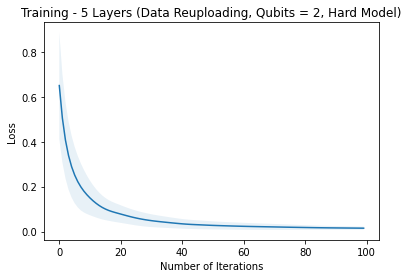

In [17]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 5 Layers (Data Reuploading, Qubits = 2, Hard Model)")

In [18]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer5Easy/quantum_loss_easy_layer5_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

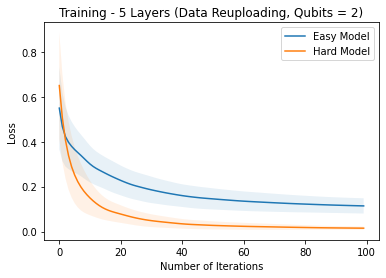

In [19]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 5 Layers (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)